In [1]:
def le2etEC(x):
    #Apply on daily total LE [W/m2]
    # from Ecological Climatology p.193
    cond = 2500.8-(2.36*x.TA)+(0.0016*(x.TA**2))+(0.00006*(x.TA**3)) #J/g latent head as a fxn of temperature
    cond *= 1000. # convert J/g -> J/kg
    #hv = 2.454*(10**6) # latent heat of vaporization
    ET = x.LE/cond # compute ET as kg/m2/s
    ET *= 86400. # number of seconds in a day
    
    return ET  # mm/m2

In [2]:
dat = pd.read_csv('./data/AMF_US-Vcm_BASE-BADM_4-1/AMF_US-Vcm_BASE_HH_4-1.csv', skiprows=2,na_values=-9999)

In [3]:
dat.head()

,TIMESTAMP_START,TIMESTAMP_END,USTAR,TA,WD,WS,NEE_PI,FC,SC,H,...,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,RECO_PI,APAR,PPFD_DIF,FAPAR,ZL
0,200701010000,200701010030,0.406,-1.826,218.498,3.143,-0.068,-0.068,NaN,-93.667,...,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
1,200701010030,200701010100,0.665,-1.503,227.079,5.297,0.152,0.152,NaN,-97.582,...,NaN,NaN,NaN,NaN,NaN,0.152,NaN,NaN,NaN,NaN
2,200701010100,200701010130,0.526,-1.184,228.058,4.600,0.202,0.202,NaN,-86.150,...,NaN,NaN,NaN,NaN,NaN,0.202,NaN,NaN,NaN,NaN
3,200701010130,200701010200,0.456,-0.917,225.522,4.354,-0.074,-0.074,NaN,-71.682,...,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
4,200701010200,200701010230,0.435,-1.523,222.867,4.375,0.055,0.055,NaN,-57.628,...,NaN,NaN,NaN,NaN,NaN,0.055,NaN,NaN,NaN,NaN


In [4]:
def make_dt(dt):
    dt = str(dt)

    YYYY = dt[0:4]
    MM = dt[4:6]
    DD = dt[6:8]
    HH = dt[8:10]
    mm = dt[10:12]

    return '%s-%s-%s %s:%s'%(YYYY,MM,DD,HH,mm)

In [5]:
dat['dt'] = dat.TIMESTAMP_END.map(make_dt)

In [6]:
dat['ET'] = dat.apply(le2etEC,axis=1)

In [7]:
dat.index = pd.DatetimeIndex(dat.dt)

In [8]:
# interpolate missing values
dat.loc[np.isnan(dat.P),'P'] = 0
dat.TA.interpolate(inplace=True)

In [9]:
dat.columns

Index([u'TIMESTAMP_START', u'TIMESTAMP_END', u'USTAR', u'TA', u'WD', u'WS',
       u'NEE_PI', u'FC', u'SC', u'H', u'SH', u'LE', u'SLE', u'G', u'TS_1',
       u'TS_2', u'P', u'RH', u'PA', u'CO2_1', u'CO2_2', u'VPD_PI', u'SWC_1',
       u'SWC_2', u'NETRAD', u'PPFD_IN', u'SW_IN', u'SW_DIF', u'PPFD_OUT',
       u'SW_OUT', u'LW_IN', u'LW_OUT', u'H2O', u'RECO_PI', u'APAR',
       u'PPFD_DIF', u'FAPAR', u'ZL', u'dt', u'ET'],
      dtype='object')

In [10]:
Vcm = pd.DataFrame({'Tmin':dat.resample('D',how='min').TA,
                   'Tmax':dat.resample('D',how='max').TA,
                   'Tave':dat.resample('D',how='mean').TA,
                   'P':dat.resample('D',how='sum').P/1000,
                  'ET':dat.resample('D',how='mean').ET})

In [11]:
Vcm.to_pickle('./data/VCM_2.pcl')

In [12]:
dat['rain_duration'] = 0
dat.loc[dat.P>0,'rain_duration'] = 0.5
Vcm['rain_duration'] = dat.resample('D', how='sum').rain_duration

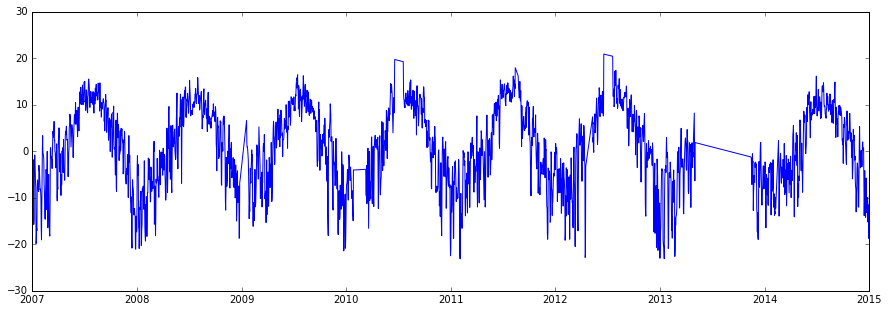

In [13]:
plt.figure(figsize=(15,5));
plt.plot(Vcm.Tmin);

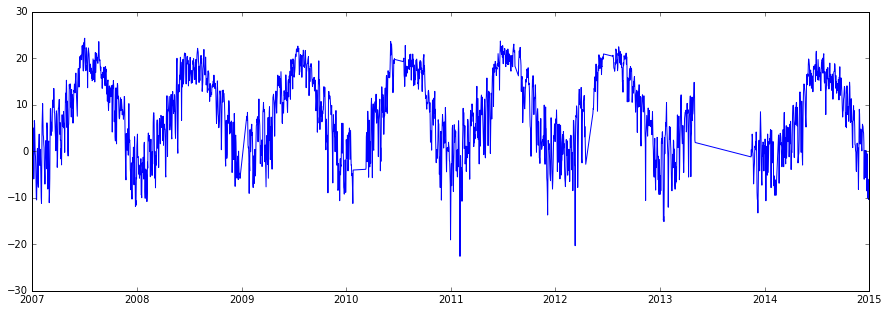

In [14]:
plt.figure(figsize=(15,5));
plt.plot(Vcm.Tmax);

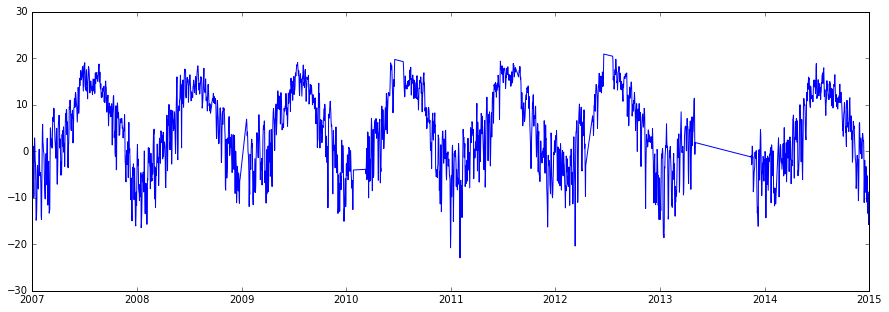

In [15]:
plt.figure(figsize=(15,5));
plt.plot(Vcm.Tave);

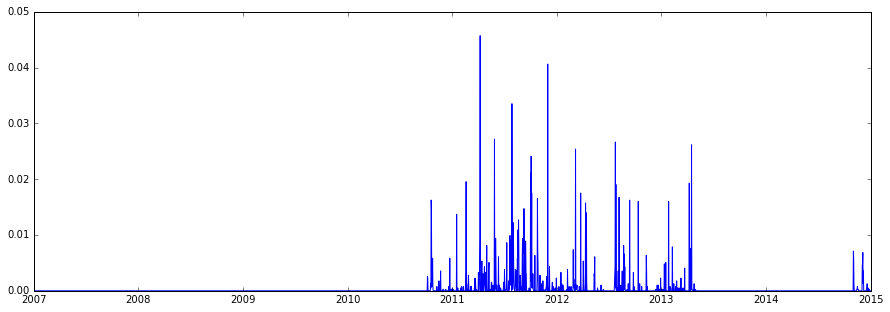

In [16]:
plt.figure(figsize=(15,5));
plt.plot(Vcm.P);

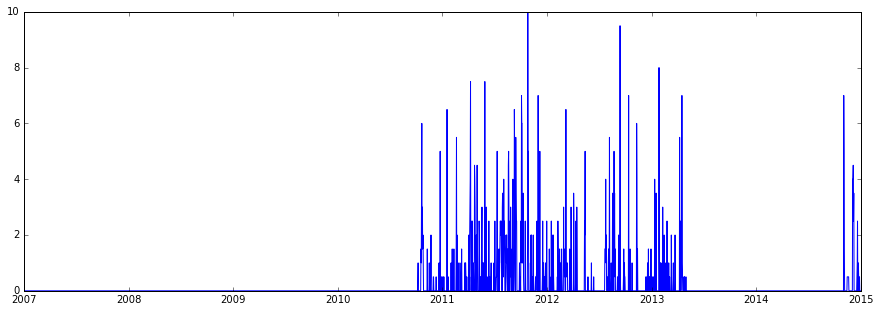

In [17]:
plt.figure(figsize=(15,5));
plt.plot(Vcm.rain_duration);

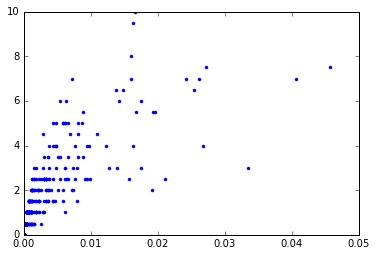

In [21]:
plt.plot(Vcm.P,Vcm.rain_duration,'.')

In [25]:
# set the crop limits 
datmin = '2010-10-01'
datmax = '2013-04-30'

In [26]:
Vcm2 = Vcm.loc['2010-10-01':'2012-10-01']
Vcm = Vcm.loc[datmin:datmax].copy()

### Make an extended set of forcings where the last 2 years are correct in time

In [31]:
wy1 = Vcm2['2010-10-01':'2011-09-30'].copy()
wy2 = Vcm2['2011-10-01':'2012-09-30'].copy() # leap year

In [32]:
wy1.reset_index(inplace=1)
wy2.reset_index(inplace=1)

In [36]:
dat = pd.concat([wy2,wy1,wy1,wy1,wy2,wy1,wy1,wy1,wy2],axis=0)

In [37]:
dat.index = pd.DatetimeIndex(pd.date_range(start='2003-10-01', end='2012-09-30'))

In [38]:
dat.head()

,index,ET,P,Tave,Tmax,Tmin,rain_duration
2003-10-01,2011-10-01,3.584586,0.000000,11.800958,14.653,9.537,0.0
2003-10-02,2011-10-02,2.369200,0.021082,9.968479,13.666,7.400,2.5
2003-10-03,2011-10-03,1.667259,0.001778,8.300771,11.380,6.115,1.0
2003-10-04,2011-10-04,1.523784,0.024130,5.458208,7.627,2.409,7.0
2003-10-05,2011-10-05,5.884047,0.005334,3.887917,5.422,2.051,6.0


In [39]:
dat.tail()

,index,ET,P,Tave,Tmax,Tmin,rain_duration
2012-09-26,2012-09-26,2.711237,0.000000,8.902146,11.865,4.277,0.0
2012-09-27,2012-09-27,1.741671,0.000762,10.150021,13.925,7.955,1.0
2012-09-28,2012-09-28,3.670329,0.000254,8.608458,12.471,4.974,0.5
2012-09-29,2012-09-29,2.711660,0.000254,8.644896,12.953,4.206,0.5
2012-09-30,2012-09-30,3.944699,0.000000,10.892667,15.058,7.885,0.0


## Now add the end of the time series on.

In [40]:
tail = Vcm['2012-10-01':datmax]

In [41]:
dat = pd.concat([dat,tail],axis=0)

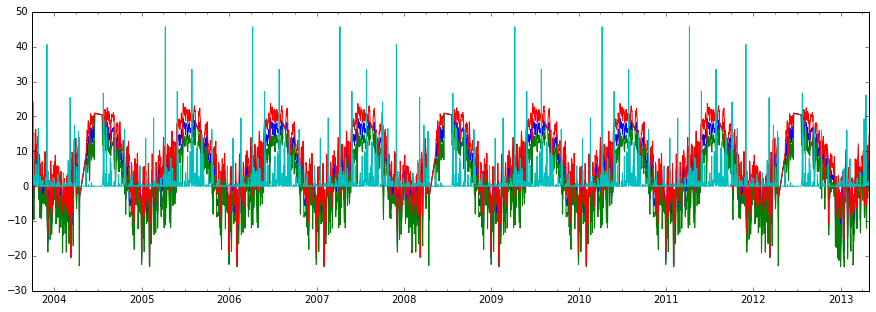

In [46]:
plt.figure(figsize=(15,5))
dat.Tave.plot()
dat.Tmin.plot()
dat.Tmax.plot()
(dat.P*1000.).plot()

In [47]:
header = '%s %s %s'%(dat.index[0].year,dat.index[0].month,dat.index[0].day)

In [49]:
np.savetxt('/RHESSys/jemez/clim/Vcm_tower_long.rain',dat.P,fmt='%f',header=header,comments='')
np.savetxt('/RHESSys/jemez/clim/Vcm_tower_long.daytime_rain_duration',dat.rain_duration,fmt='%f',header=header,comments='')
np.savetxt('/RHESSys/jemez/clim/Vcm_tower_long.tmin',dat.Tmin,fmt='%f',header=header,comments='')
np.savetxt('/RHESSys/jemez/clim/Vcm_tower_long.tmax',dat.Tmax,fmt='%f',header=header,comments='')
np.savetxt('/RHESSys/jemez/clim/Vcm_tower_long.tavg',dat.Tave,fmt='%f',header=header,comments='')